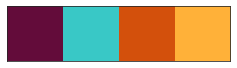

In [1]:
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#set font size of labels on matplotlib plots
plt.rc('font', size=16)

#set style of plots
sns.set_style('white')

#define a custom palette
customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139']
sns.set_palette(customPalette)
sns.palplot(customPalette)

In [2]:
class Iris:

    def __init__(self,k):
        self.m = 150
        self.n = 4
        self.k = k

    def getK(self):
        return self.k

    def getData(self):

        try:
            data = np.genfromtxt('data/iris.csv', delimiter=',')
            print("Data source available.")
        except IOError:
            print("Missing dataset! Run:")
            print(
                "wget http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data")
            exit(0)
        print("Shape of original data : " + str(len(data)) +
              ", " + str(len(data[0])))
        return data

    def normalizeData(self, data):
        print("Normalizing the data to to range [0,1] now...")
        low, high = np.amin(data, axis=0), np.amax(data, axis=0)
        for j in range(self.n):
            minimum, maximum = low[j], high[j]
            for i in range(self.m):
                data[i][j] = (data[i][j] - minimum)/(maximum - minimum)
        print("Shape of the normalized data : " +
              str(len(data)) + ", " + str(len(data[0])))
        return data

    def getDissimilarityMatrix(self, data):
        print("Preparing dissimilarity matrix...")
        mat = np.zeros(shape=(self.m, self.m))
        for i in range(self.m):
            for j in range(self.m):
                mat[i, j] = ((data[i][0] - data[j][0])**2 + (data[i][1] - data[j][1]
                                                             )**2 + (data[i][2] - data[j][2])**2 + (data[i][3] - data[j][3])**2)**0.5
        print("Shape of the Dissimilarity Matrix : " +
              str(len(mat)) + ", " + str(len(mat[0])))
        return mat

    def cluster(self, mat):
        print("Calculating average dissimilarity values for each object...")
        avg = np.mean(mat, axis=0)
        print("Primary clustering...")
        clusters = []
        for i in range(self.m):
            cluster = []
            for j in range(self.m):
                if(mat[i][j] < avg[i]):
                    cluster.append(j)
            clusters.append(cluster)
        print(str(len(clusters)) + " primary clusters formed.")
        print("---------------------------------------------------------------")
        return clusters

    def removeSubsetClusters(self, clusters):
        print("Removing clusters which are a subset of other clusters...")
        num_clusters = len(clusters)
        i = 0
        while i < num_clusters:
            j = 0
            while j < num_clusters:
                if i != j:
                    if (set(clusters[i]).issubset(set(clusters[j]))):
                        clusters.remove(clusters[i])
                        num_clusters -= 1
                        i -= 1
                        break
                j += 1
            i += 1
        return clusters

    def getSimilarityMatrix(self, clusters):
        print("Creating similarity matrix...")
        p = len(clusters)
        sim = np.zeros(shape=(p, p))
        for i in range(p):
            for j in range(p):
                sim[i, j] = len(list(set(clusters[i]) & set(clusters[j]))) / \
                    len(list(set(clusters[i]) | set(clusters[j])))
        print("Shape of the Similarity Matrix : " +
              str(len(sim)) + ", " + str(len(sim[0])))
        return sim

    def mergeMaxSimilarityClusters(self, sim, clusters):
        print("Merging clusters having maximum similarity...")
        print(print(str(len(clusters)) + " clusters found."))
        val = 0
        idx_k = -1
        idx_l = -1
        p = len(clusters)
        for i in range(p):
            for j in range(p):
                if(i != j):
                    if(sim[i, j] >= val):
                        val = sim[i, j]
                        idx_k = i
                        idx_l = j

        clusters[idx_k] = list(set(clusters[idx_k]) | set(clusters[idx_l]))
        clusters.remove(clusters[idx_l])

        print(str(val) + " is the maximum similarity value and clusters " +
              str(idx_k) + ", " + str(idx_l) + " are the most similar.")
        print(str(len(clusters)) + " clusters left after this iteration.")
        print("---------------------------------------------------------------")
        if(len(clusters) == self.k):
            if (self.k==3):
                print(str(len(clusters[0])) + ", " + str(len(clusters[1])) + ", " +
                    str(len(clusters[2])) + " are the sizes of the three clusters.")
            if(self.k==2):
                print(str(len(clusters[0])) + ", " + str(len(clusters[1])) + " are the sizes of the three clusters.")

        return clusters

    @classmethod
    def similarity_measure(cls, num1, num2):
        return abs(num1-num2)

    def notkMeansClustering(self, clusters):
        print("---------------------------------------------------------------")
        print("Now removing duplicates in clusters by re-clustering based on similarity to mean of the clusters formed.")
        mean = []
        for i in range(self.k):
            sum = 0
            for j in range(len(clusters[i])):
                sum += clusters[i][j]
            mean.append(sum/len(clusters[i]))

        locations = [[] for _ in range(self.m)]
        for i in range(self.m):
            for j in range(len(clusters)):
                for k in range(len(clusters[j])):
                    if (clusters[j][k] == i):
                        locations[i].append(j)
                        break

        dummy = [[] for _ in range(len(clusters))]
        for i in range(self.m):
            if (i == 0):
                dummy[i].append(i)
            else:
                obj = i
                max_similarity = 0
                max_similarity_idx = -1
                for j in range(len(locations[i])):
                    location = locations[i][j]
                    for k in range(len(clusters[location])):
                        if (clusters[location][k] == obj):
                            num1 = clusters[location][k]
                            num2 = mean[location]
                            similarity = Iris.similarity_measure(num1, num2)
                            if (similarity > max_similarity):
                                max_similarity = similarity
                                max_similarity_idx = location
                            break
                dummy[max_similarity_idx].append(i)

        clusters = dummy

        if(self.k==3):
            print(str(len(clusters[0])) + ", " + str(len(clusters[1])) + ", " +
                str(len(clusters[2])) + " are the sizes of the three final clusters.\n")
            print("Cluster 1 : \n")
            print(clusters[0])
            print("\n")
            print("Cluster 2 : \n")
            print(clusters[1])
            print("\n")
            print("Cluster 3 : \n")
            print(clusters[2])
            print("\n")

        if(self.k==2):
            print(str(len(clusters[0])) + ", " + str(len(clusters[1])) + " are the sizes of the two final clusters.\n")
            print("Cluster 1 : \n")
            print(clusters[0])
            print("\n")
            print("Cluster 2 : \n")
            print(clusters[1])
            print("\n")

        return clusters
    
    @classmethod
    def label(cls, clusters):
        # y_pred will contain the predicted class labels for the objects
        y_pred = []
        for i in range(150):
            # y[i] will indicate that i belongs to cluster-j
            obj = i
            for j in range(len(clusters)):
                for k in range(len(clusters[j])):
                    if clusters[j][k] == obj:
                        y_pred.append(j)

        # y_true has the true class labels corresponding to each object
        y_true = []
        for i in range(150):
            if i in range(0,51):
                y_true.append(0)
            elif i in range(51,101):
                y_true.append(1)
            else :
                y_true.append(2)

        return y_true, y_pred

    def plot(self, clusters, i , j):
        print("Considering features " + str(i) + " and " + str(j))
        y_true, y_pred = Iris.label(clusters)
        data = np.genfromtxt('data/iris.csv', delimiter=',')
        df_true = pd.DataFrame({'Feature_X': data[:, i], 'Feature_Y': data[:, j], 'true class': y_true})
        df_pred = pd.DataFrame({'Feature_X': data[:, i], 'Feature_Y': data[:, j], 'predicted class': y_pred})
        true_plot = sns.lmplot(data=df_true, x='Feature_X', y='Feature_Y', hue='true class', fit_reg=False, legend=True, legend_out=True)
        predicted_plot = sns.lmplot(data=df_pred, x='Feature_X', y='Feature_Y', hue='predicted class', fit_reg=False, legend=True, legend_out=True)
        print("----------------------------------------------------------------------------------------------------------------------------------")
        return


## k=3

In [3]:
model = Iris(3)
data = Iris.getData(model)
data = Iris.normalizeData(model, data)
mat = Iris.getDissimilarityMatrix(model, data)
clusters = Iris.cluster(model, mat)
cluster_original = clusters
while(len(clusters) != Iris.getK(model)):
    clusters = Iris.removeSubsetClusters(model, clusters)
    sim = Iris.getSimilarityMatrix(model, clusters)
    clusters = Iris.mergeMaxSimilarityClusters(model, sim, clusters)
clusters = Iris.notkMeansClustering(model, clusters)

Data source available.
Shape of original data : 150, 4
Normalizing the data to to range [0,1] now...
Shape of the normalized data : 150, 4
Preparing dissimilarity matrix...
Shape of the Dissimilarity Matrix : 150, 150
Calculating average dissimilarity values for each object...
Primary clustering...
150 primary clusters formed.
---------------------------------------------------------------
Removing clusters which are a subset of other clusters...
Creating similarity matrix...
Shape of the Similarity Matrix : 14, 14
Merging clusters having maximum similarity...
14 clusters found.
None
0.9789473684210527 is the maximum similarity value and clusters 13, 10 are the most similar.
13 clusters left after this iteration.
---------------------------------------------------------------
Removing clusters which are a subset of other clusters...
Creating similarity matrix...
Shape of the Similarity Matrix : 13, 13
Merging clusters having maximum similarity...
13 clusters found.
None
0.9684210526315

Considering features 0 and 1
----------------------------------------------------------------------------------------------------------------------------------


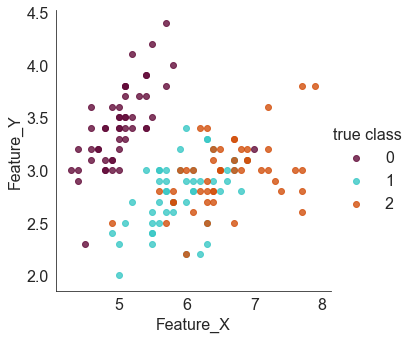

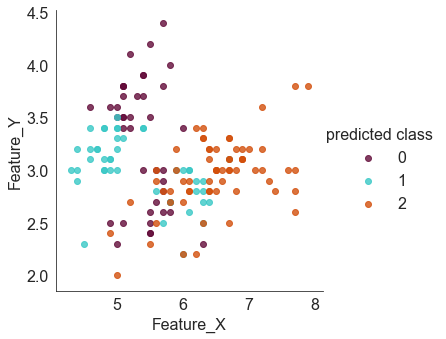

In [4]:
Iris.plot(model, clusters, 0, 1)


Considering features 0 and 2
----------------------------------------------------------------------------------------------------------------------------------


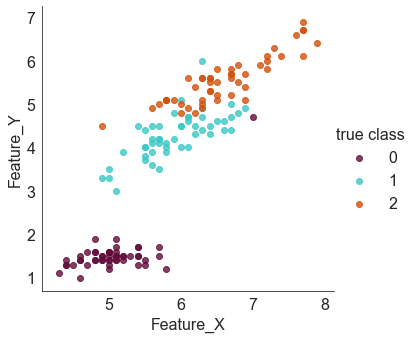

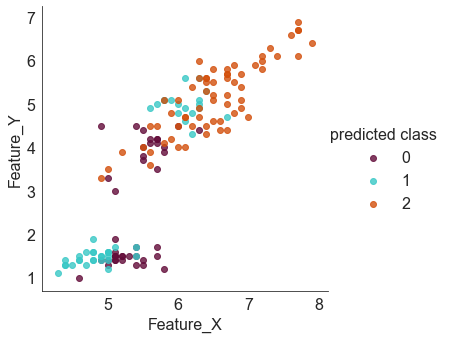

In [5]:
Iris.plot(model, clusters, 0, 2)

Considering features 0 and 3
----------------------------------------------------------------------------------------------------------------------------------


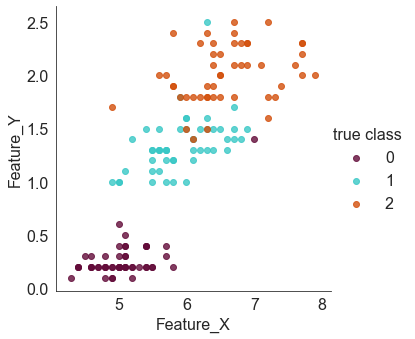

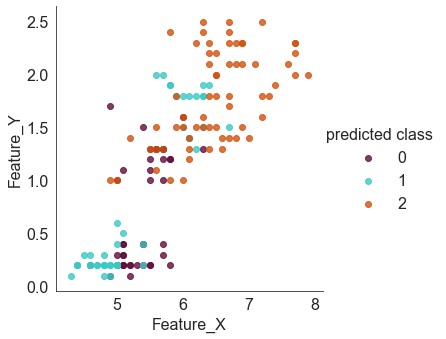

In [6]:
Iris.plot(model, clusters, 0, 3)

Considering features 1 and 2
----------------------------------------------------------------------------------------------------------------------------------


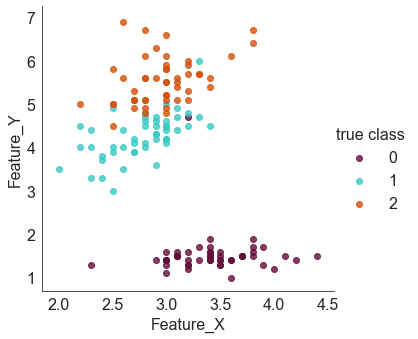

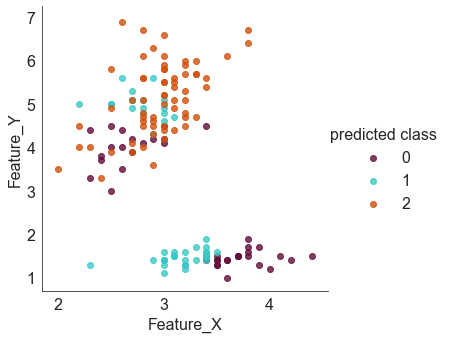

In [7]:
Iris.plot(model, clusters, 1, 2)

Considering features 1 and 3
----------------------------------------------------------------------------------------------------------------------------------


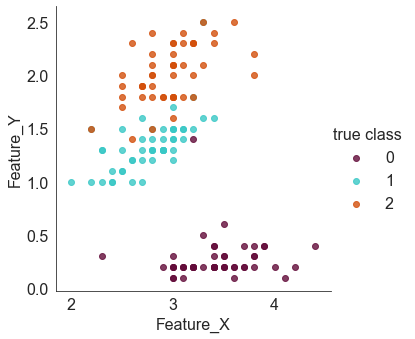

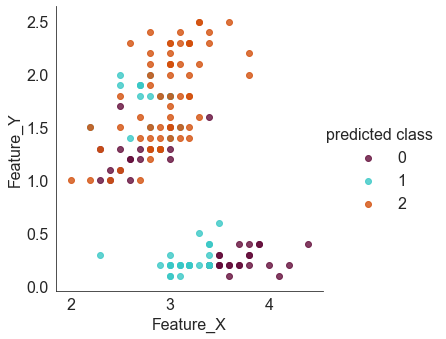

In [8]:
Iris.plot(model, clusters, 1, 3)

Considering features 2 and 3
----------------------------------------------------------------------------------------------------------------------------------


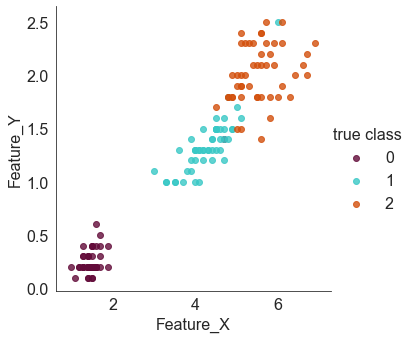

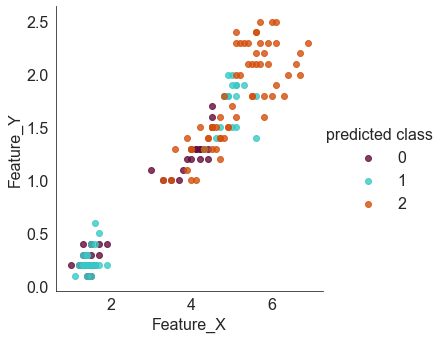

In [9]:
Iris.plot(model, clusters, 2, 3)

## k=2

In [10]:
model = Iris(2)
data = Iris.getData(model)
data = Iris.normalizeData(model, data)
mat = Iris.getDissimilarityMatrix(model, data)
clusters = Iris.cluster(model, mat)
cluster_original = clusters
while(len(clusters) != Iris.getK(model)):
    clusters = Iris.removeSubsetClusters(model, clusters)
    sim = Iris.getSimilarityMatrix(model, clusters)
    clusters = Iris.mergeMaxSimilarityClusters(model, sim, clusters)
clusters = Iris.notkMeansClustering(model, clusters)

Data source available.
Shape of original data : 150, 4
Normalizing the data to to range [0,1] now...
Shape of the normalized data : 150, 4
Preparing dissimilarity matrix...
Shape of the Dissimilarity Matrix : 150, 150
Calculating average dissimilarity values for each object...
Primary clustering...
150 primary clusters formed.
---------------------------------------------------------------
Removing clusters which are a subset of other clusters...
Creating similarity matrix...
Shape of the Similarity Matrix : 14, 14
Merging clusters having maximum similarity...
14 clusters found.
None
0.9789473684210527 is the maximum similarity value and clusters 13, 10 are the most similar.
13 clusters left after this iteration.
---------------------------------------------------------------
Removing clusters which are a subset of other clusters...
Creating similarity matrix...
Shape of the Similarity Matrix : 13, 13
Merging clusters having maximum similarity...
13 clusters found.
None
0.9684210526315

Considering features 0 and 1
----------------------------------------------------------------------------------------------------------------------------------


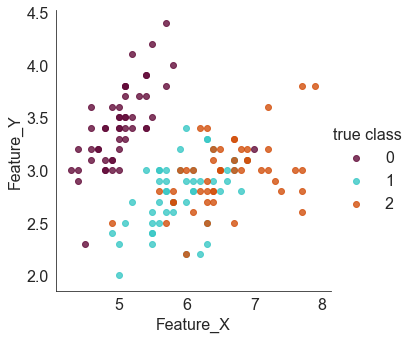

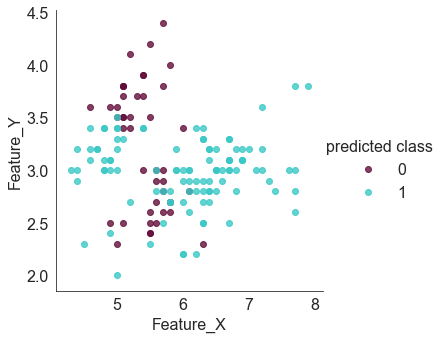

In [11]:
Iris.plot(model, clusters, 0, 1)

Considering features 0 and 2
----------------------------------------------------------------------------------------------------------------------------------


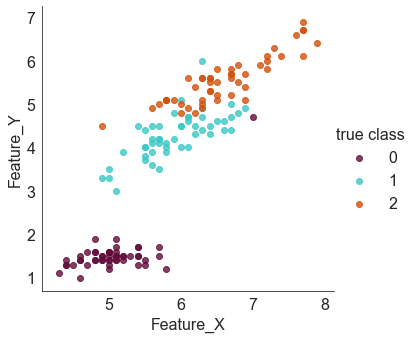

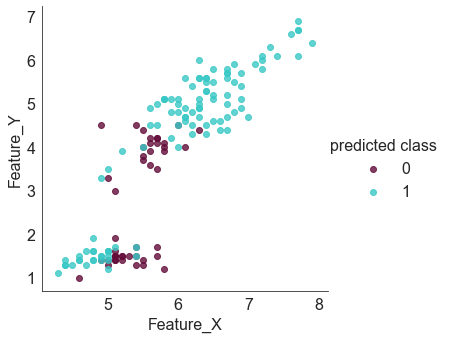

In [12]:
Iris.plot(model, clusters, 0, 2)

Considering features 0 and 3
----------------------------------------------------------------------------------------------------------------------------------


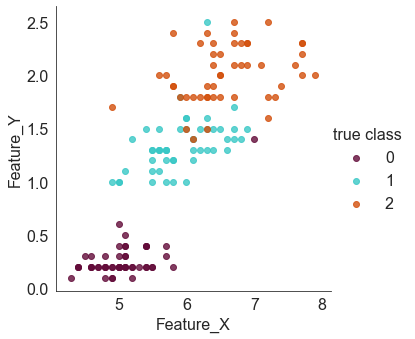

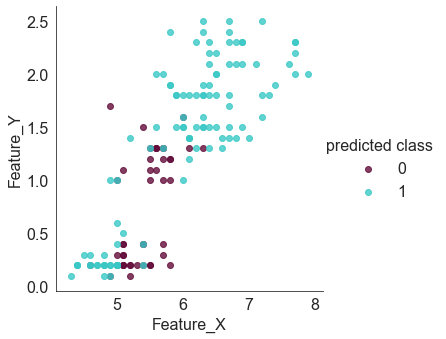

In [13]:
Iris.plot(model, clusters, 0, 3)

Considering features 1 and 2
----------------------------------------------------------------------------------------------------------------------------------


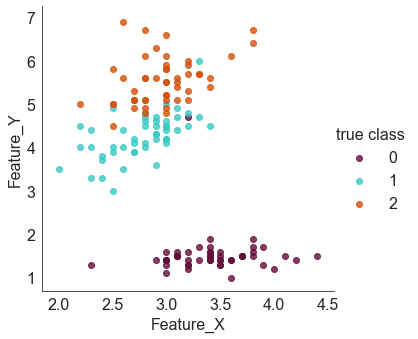

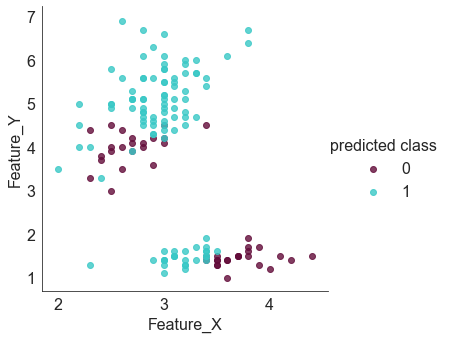

In [14]:
Iris.plot(model, clusters, 1, 2)

Considering features 1 and 3
----------------------------------------------------------------------------------------------------------------------------------


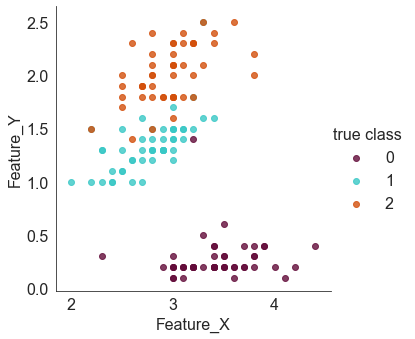

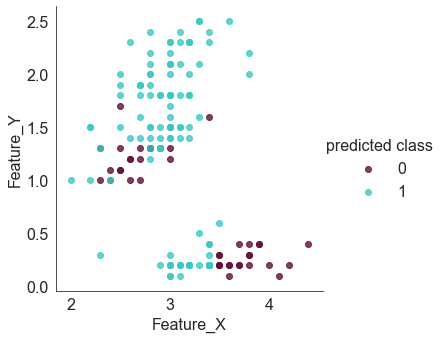

In [15]:
Iris.plot(model, clusters, 1, 3)

Considering features 2 and 3
----------------------------------------------------------------------------------------------------------------------------------


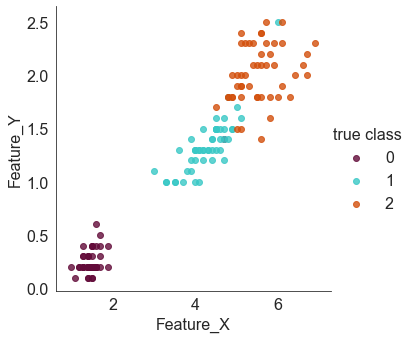

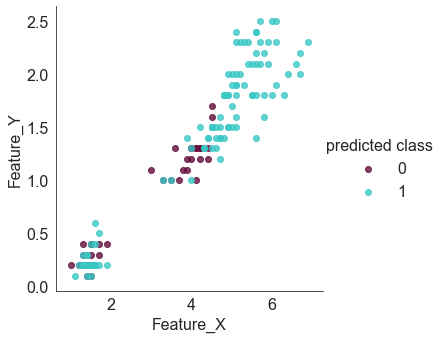

In [16]:
Iris.plot(model, clusters, 2, 3)